In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import umap
import hdbscan

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
data = pd.read_csv('CPS.csv')

In [4]:
# Replace NaN values with -1
data.fillna(-1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126784 entries, 0 to 126783
Columns: 389 entries, hrhhid2 to gtindvpc
dtypes: float64(342), int64(47)
memory usage: 376.3 MB


In [6]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

In [7]:
# Set a high correlation threshold
high_corr_threshold = 0.98

# Find features with correlation greater than 0.98 or less than -0.98
highly_corr_vars = set()
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > high_corr_threshold or correlation_matrix.loc[row, col] < -high_corr_threshold) and row != col:
            highly_corr_vars.add(tuple(sorted((row, col))))

# Remove one of each pair 
columns_to_remove = set()
for var1, var2 in highly_corr_vars:
    # Add one of the pair to the set to be removed
    columns_to_remove.add(var1) 

# Drop the columns from the dataframe
data_reduced = data.drop(columns=columns_to_remove)

In [8]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126784 entries, 0 to 126783
Columns: 341 entries, hrhhid2 to gtindvpc
dtypes: float64(294), int64(47)
memory usage: 329.8 MB


In [9]:

data_reduced['pecert1']

0         2.0
1        -1.0
2        -1.0
3         2.0
4         2.0
         ... 
126779   -1.0
126780   -1.0
126781   -1.0
126782   -1.0
126783   -1.0
Name: pecert1, Length: 126784, dtype: float64

In [10]:
# Calculate the percentage of -1 in each column
perc_na = (data_reduced == -1).mean()

# Identify columns where more than 40% of the data is -1
columns_to_drop = perc_na[perc_na > 0.4].index

# Drop these columns from the dataframe in place
data_reduced.drop(columns=columns_to_drop, inplace=True)

In [11]:
# Counting the number of columns using shape
data_reduced.shape[1]


106

In [12]:
# iterates over each column, converts float to categorical, and integer from int64 to int32 to save memory

for col in data_reduced.columns:
    if data_reduced[col].dtype == 'float64':
        data_reduced[col] = data_reduced[col].astype('category')
    elif data_reduced[col].dtype == 'int64':
        data_reduced[col] = data_reduced[col].astype('int32')


In [13]:
# Define the preprocessing for numeric and categorical data
numeric_features = data_reduced.select_dtypes(include=['int32', 'float64']).columns.tolist()
categorical_features = data_reduced.select_dtypes(include=['category']).columns.tolist()

# Preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

#  Preprocess the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data_transformed = pipeline.fit_transform(data_reduced)

In [14]:
data_transformed.shape

(126784, 200772)

In [15]:
# Reduce dimensions with UMAP
reducer = umap.UMAP(n_neighbors=50, n_components=7, min_dist=0.0)
embedding = reducer.fit_transform(data_transformed)


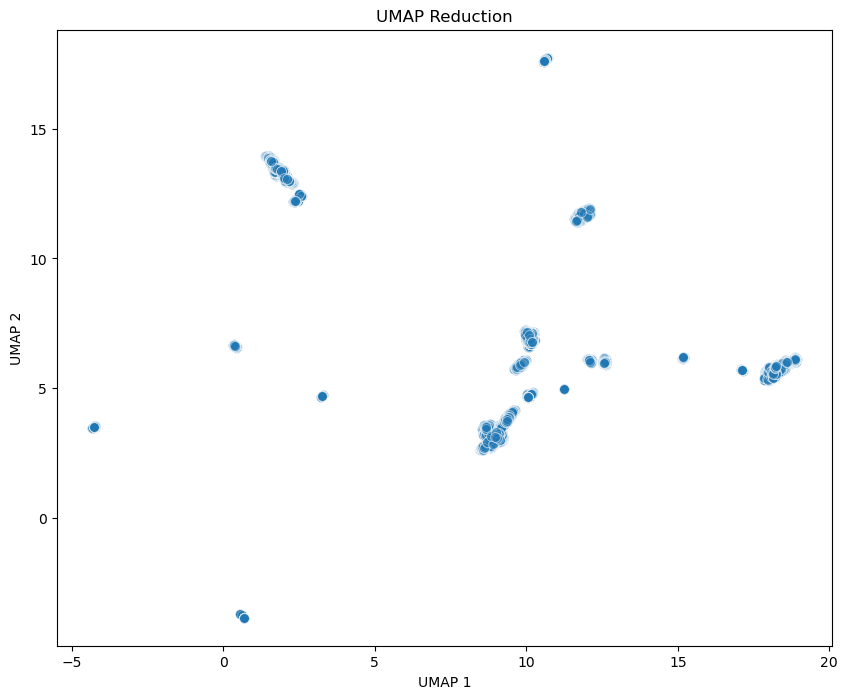

In [16]:
# Visualize the embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=50, alpha=0.6, legend='full')
plt.title('UMAP Reduction')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


Looking at the UMAP plot you've uploaded, there are several distinct clusters visible, which suggests that the dimensionality reduction has effectively captured meaningful structures in the data. Here’s how to proceed based on this visualization:

1. Analyzing the UMAP Output:
The plot shows multiple clusters, some tightly packed and others more dispersed. This indicates varied density across clusters, which is important for the next step with HDBSCAN, as it works well with data having such characteristics.
2. Choosing Parameters for HDBSCAN:
Based on the distribution of points in your UMAP output, you'll want to choose min_cluster_size and min_samples in HDBSCAN thoughtfully. Smaller clusters suggest a smaller min_cluster_size might be appropriate, but if you want to ensure that smaller groupings are not considered noise, slightly increasing min_cluster_size might be beneficial.
For the min_samples parameter, which affects how conservative the clustering is (higher values lead to fewer clusters), you might start with a value close to or slightly below the min_cluster_size to balance sensitivity and specificity.

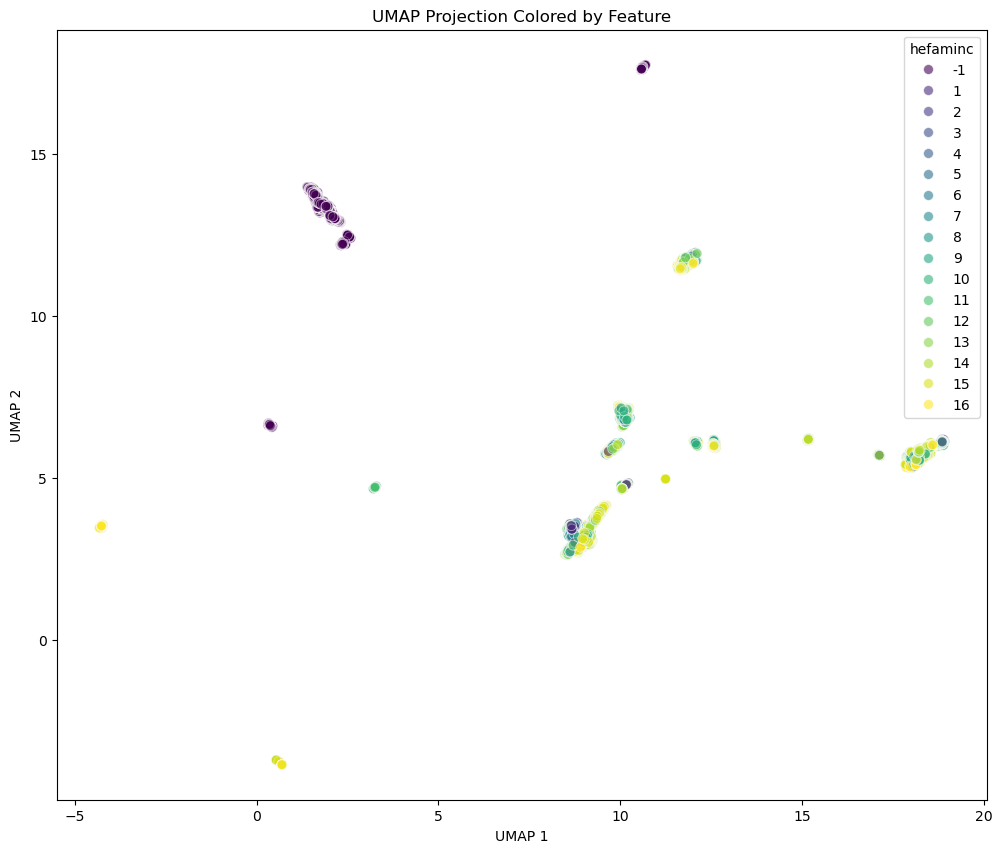

In [17]:
# Visualize a feature of interest in the original data
feature_of_interest = 'hefaminc'
plt.figure(figsize=(12, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=data_reduced[feature_of_interest], palette='viridis', s=50, alpha=0.6, legend='full')
plt.title('UMAP Projection Colored by Feature')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

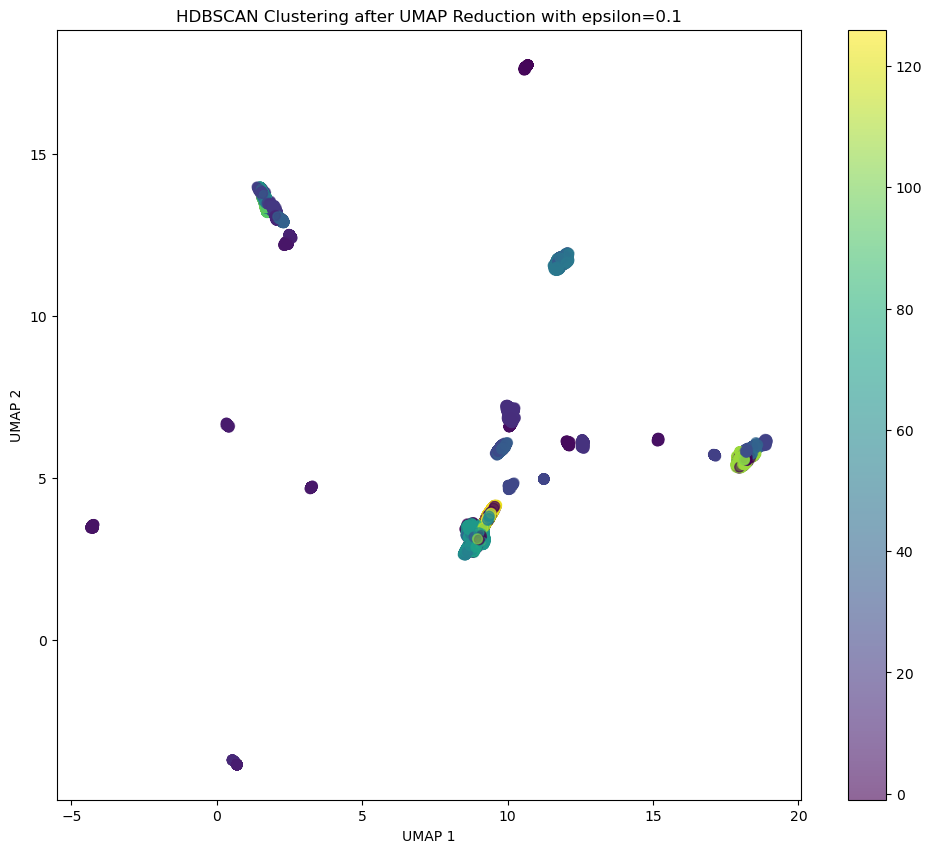

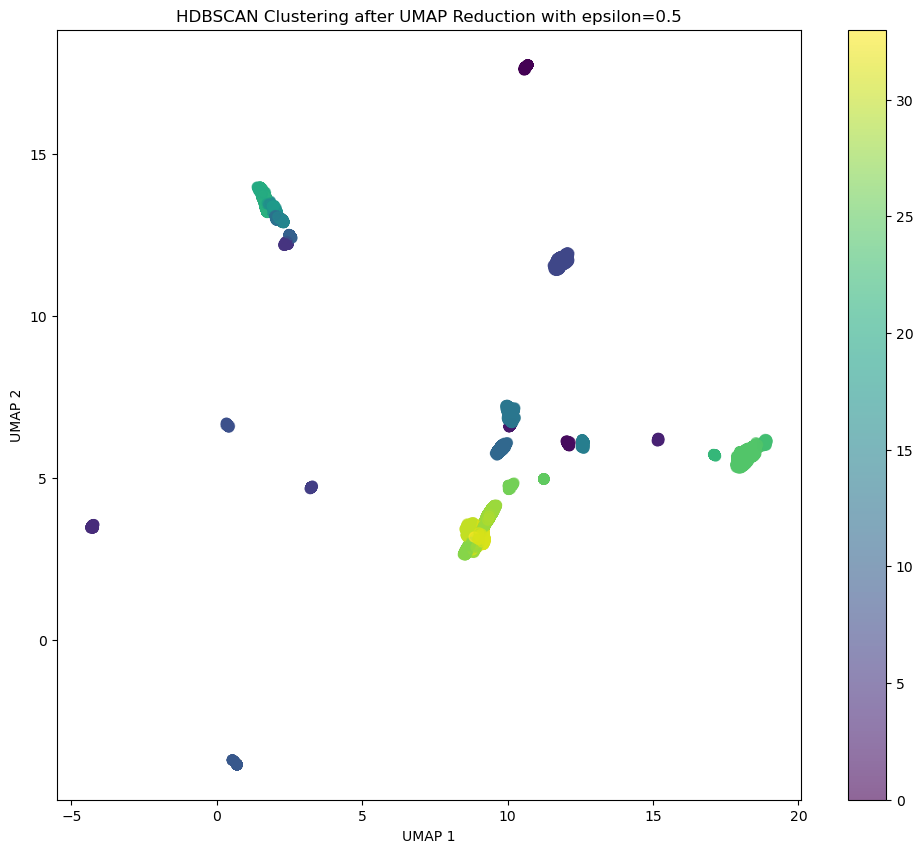

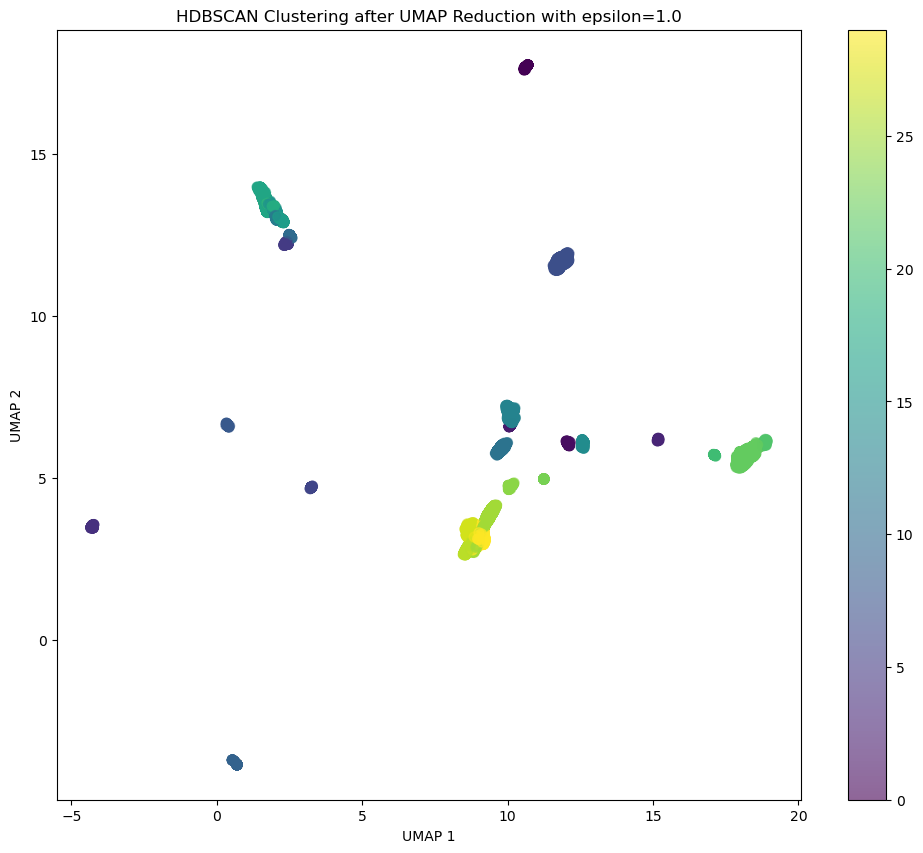

In [18]:
for epsilon in [0.1, 0.5, 1.0]:  # Exploring different epsilon values
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=epsilon)
    cluster_labels = clusterer.fit_predict(embedding)

    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot. 'c' is used for coloring based on labels.
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
    
    # Add a colorbar to the plot
    plt.colorbar(scatter)
    
    # Add titles and labels
    plt.title(f'HDBSCAN Clustering after UMAP Reduction with epsilon={epsilon}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Show the plot
    plt.show()

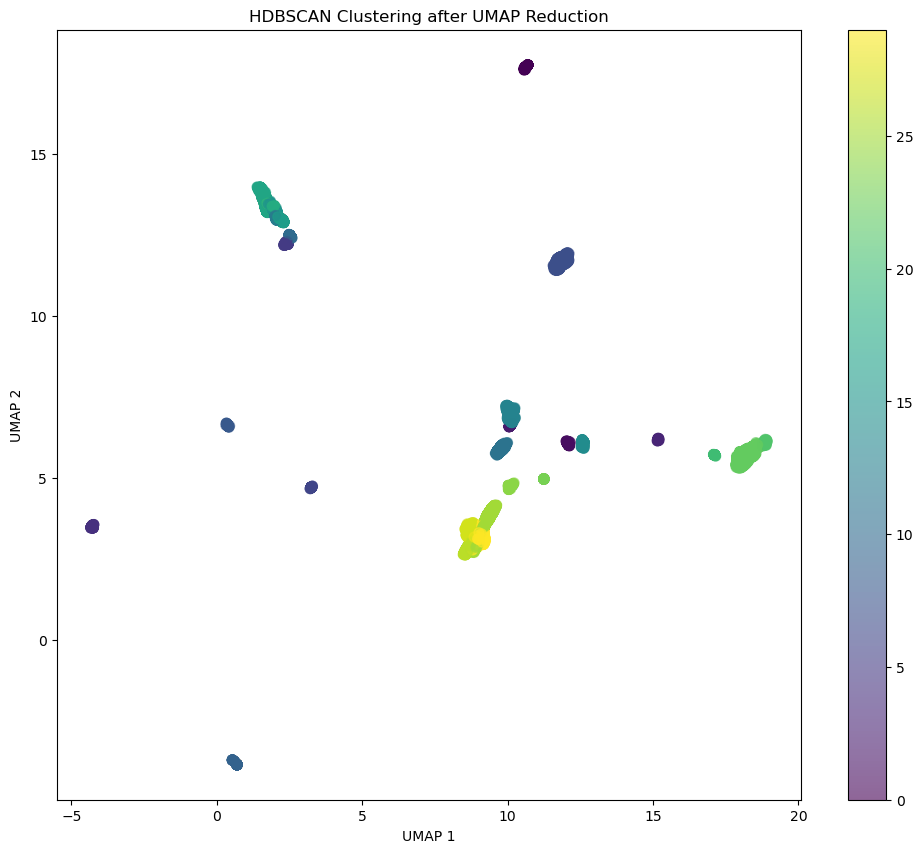

In [19]:
# Assuming 'embedding' is the output from UMAP that you plotted
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=1)
cluster_labels = clusterer.fit_predict(embedding)

plt.figure(figsize=(12, 10))

# Create a scatter plot. 'c' is used for coloring based on labels.
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)

# Add a colorbar to the plot
plt.colorbar(scatter)

# Add titles and labels
plt.title('HDBSCAN Clustering after UMAP Reduction')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show the plot
plt.show()

In [20]:
data_reduced['Cluster_Labels'] = cluster_labels

# Exploring Clusters


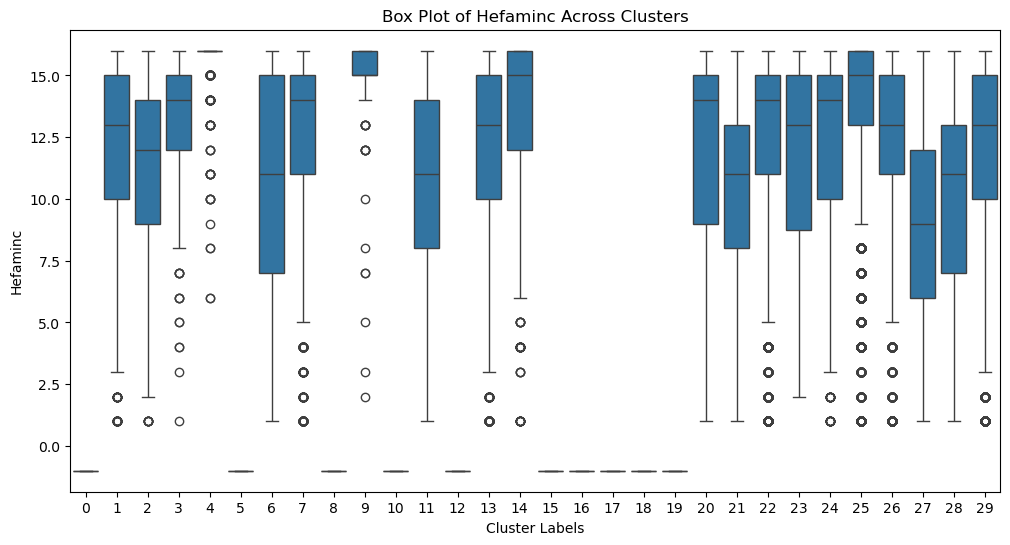

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Labels', y='hefaminc', data=data_reduced)
plt.title('Box Plot of Hefaminc Across Clusters')
plt.xlabel('Cluster Labels')
plt.ylabel('Hefaminc')
plt.show()

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Labels', y='pewa', data=data_reduced)
plt.title('Box Plot of Hefaminc Across Clusters')
plt.xlabel('Cluster Labels')
plt.ylabel('Hefaminc')
plt.show()

ValueError: Could not interpret value `pewa` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>